# `NevergradOptimizer` Tutorial

This tutorial demonstrates how to use the `NevergradOptimizer` from BrainTools for black-box optimization problems. The NevergradOptimizer is a powerful wrapper around the [Nevergrad](https://github.com/facebookresearch/nevergrad) library that provides batched evaluation support and seamless integration with JAX and BrainUnit.

## Introduction and Setup

The `NevergradOptimizer` is designed for derivative-free optimization where gradients are unavailable or unreliable. It's particularly useful for:
- Hyperparameter optimization
- Neural architecture search
- Complex loss landscapes
- Noisy objective functions

Let's start by importing the necessary libraries:

In [1]:
import brainunit as u
import braintools
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

print("BrainTools version:", braintools.__version__)
print("JAX version:", jax.__version__)

BrainTools version: 0.0.12
JAX version: 0.7.1


First, let's check if Nevergrad is installed (it's required for the optimizer to work):

In [2]:
try:
    import nevergrad as ng

    print(f"Nevergrad version: {ng.__version__}")
    print("✓ Nevergrad is available")
except ImportError:
    print("❌ Nevergrad is not installed. Please install it with:")
    print("   pip install nevergrad")
    raise

Nevergrad version: 1.0.12
✓ Nevergrad is available


## Basic Usage: Scalar Optimization

Let's start with a simple example: optimizing a basic quadratic function with two scalar parameters.

In [3]:
# Define a simple quadratic loss function
def quadratic_loss(x, y):
    """
    Batched quadratic loss function.
    
    Args:
        x, y: JAX arrays of shape (n_sample,)
        
    Returns:
        Array of losses, shape (n_sample,)
    """
    return (x - 2.0) ** 2 + (y + 1.0) ** 2


# Define bounds for each parameter: (min, max)
bounds = [
    (-5.0, 5.0),  # bounds for x
    (-3.0, 3.0),  # bounds for y
]

# Create the optimizer
optimizer = braintools.optim.NevergradOptimizer(
    batched_loss_fun=quadratic_loss,
    bounds=bounds,
    n_sample=10,  # Number of candidates per iteration
    method='DE'  # Differential Evolution
)

print("Optimizer created successfully!")
print(f"Method: {optimizer.method}")
print(f"Population size: {optimizer.n_sample}")

Optimizer created successfully!
Method: DE
Population size: 10


In [4]:
# Run the optimization
best_params = optimizer.minimize(n_iter=20, verbose=True)

print(f"\nOptimization completed!")
print(f"Best parameters: x={best_params[0]:.4f}, y={best_params[1]:.4f}")
print(f"True optimum: x=2.0, y=-1.0")
print(f"Final loss: {quadratic_loss(best_params[0], best_params[1]):.6f}")

Iteration 0, best error: 0.25561, best parameters: [1.5779222385288518, -0.7216862168441729]
Iteration 1, best error: 0.22335, best parameters: [2.179454790119798, -0.5627973574184901]
Iteration 2, best error: 0.22335, best parameters: [2.179454790119798, -0.5627973574184901]
Iteration 3, best error: 0.01908, best parameters: [2.1325511093016987, -0.9610894268195804]
Iteration 4, best error: 0.01830, best parameters: [1.8810521585283122, -0.9355450228396044]
Iteration 5, best error: 0.01830, best parameters: [1.8810521585283122, -0.9355450228396044]
Iteration 6, best error: 0.01830, best parameters: [1.8810521585283122, -0.9355450228396044]
Iteration 7, best error: 0.00248, best parameters: [1.9688748933374687, -0.9610894268195804]
Iteration 8, best error: 0.00248, best parameters: [1.9688748933374687, -0.9610894268195804]
Iteration 9, best error: 0.00248, best parameters: [1.9688748933374687, -0.9610894268195804]
Iteration 10, best error: 0.00248, best parameters: [1.9688748933374687,

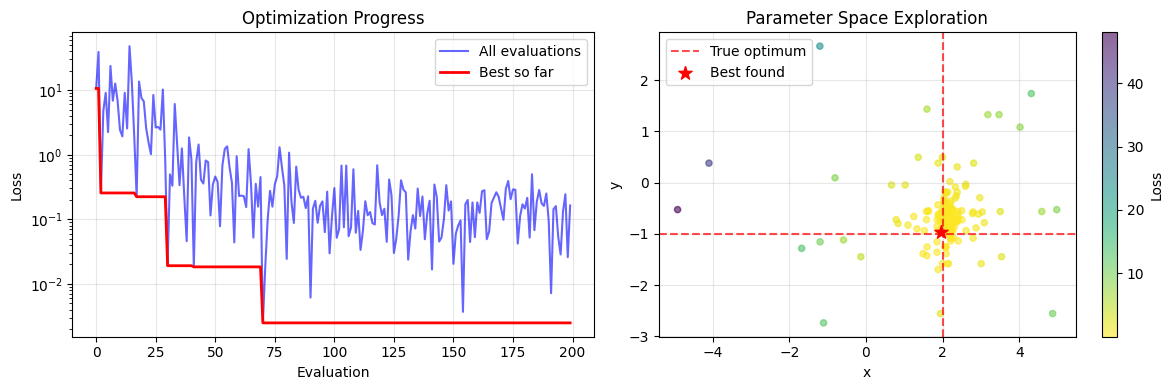

In [5]:
# Visualize the optimization progress
plt.figure(figsize=(12, 4))

# Plot error evolution
plt.subplot(1, 2, 1)
plt.plot(optimizer.errors, 'b-', alpha=0.6, label='All evaluations')
# Plot best so far
best_so_far = np.minimum.accumulate(optimizer.errors)
plt.plot(best_so_far, 'r-', linewidth=2, label='Best so far')
plt.yscale('log')
plt.xlabel('Evaluation')
plt.ylabel('Loss')
plt.title('Optimization Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot parameter evolution
plt.subplot(1, 2, 2)
candidates = np.array(optimizer.candidates)
plt.scatter(candidates[:, 0], candidates[:, 1], c=optimizer.errors,
            cmap='viridis_r', alpha=0.6, s=20)
plt.colorbar(label='Loss')
plt.axvline(x=2.0, color='red', linestyle='--', alpha=0.7, label='True optimum')
plt.axhline(y=-1.0, color='red', linestyle='--', alpha=0.7)
plt.scatter(best_params[0], best_params[1], color='red', s=100,
            marker='*', label='Best found', zorder=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Parameter Space Exploration')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Multi-dimensional Parameter Optimization

The NevergradOptimizer can handle multi-dimensional parameters (arrays) as well as scalars. Let's optimize a function with array parameters.

In [6]:
# Define a loss function with array parameters
def matrix_loss(W, b):
    """
    Loss function with matrix and vector parameters.
    
    Args:
        W: JAX array of shape (n_sample, 3, 2) - batch of 3x2 matrices
        b: JAX array of shape (n_sample, 2) - batch of 2D vectors
        
    Returns:
        Array of losses, shape (n_sample,)
    """
    # Target matrix and bias
    W_target = jnp.array([[1.0, -0.5], [0.3, 1.2], [-0.8, 0.9]])
    b_target = jnp.array([0.1, -0.3])

    # Compute Frobenius norm of differences
    W_diff = W - W_target[None, :, :]
    b_diff = b - b_target[None, :]

    return jnp.sum(W_diff ** 2, axis=(1, 2)) + jnp.sum(b_diff ** 2, axis=1)


# Define bounds for array parameters
bounds = [
    (jnp.full((3, 2), -2.0), jnp.full((3, 2), 2.0)),  # bounds for W (3x2 matrix)
    (jnp.full(2, -1.0), jnp.full(2, 1.0)),  # bounds for b (2D vector)
]

# Create optimizer with more sophisticated method
optimizer = braintools.optim.NevergradOptimizer(
    batched_loss_fun=matrix_loss,
    bounds=bounds,
    n_sample=20,
    method='CMA'  # Covariance Matrix Adaptation
)

print("Multi-dimensional optimizer created!")
print(f"Parameter shapes: W={bounds[0][0].shape}, b={bounds[1][0].shape}")

Multi-dimensional optimizer created!
Parameter shapes: W=(3, 2), b=(2,)


In [7]:
# Run optimization
best_params = optimizer.minimize(n_iter=15, verbose=True)

W_best, b_best = best_params
print(f"\nBest W matrix:")
print(W_best)
print(f"\nBest b vector:")
print(b_best)

# Compare with targets
W_target = jnp.array([[1.0, -0.5], [0.3, 1.2], [-0.8, 0.9]])
b_target = jnp.array([0.1, -0.3])
print(f"\nTarget W matrix:")
print(W_target)
print(f"\nTarget b vector:")
print(b_target)

print(f"\nFinal loss: {matrix_loss(W_best[None, :, :], b_best[None, :])[0]:.6f}")

Iteration 0, best error: 3.06228, best parameters: [array([[ 0.1319265 ,  0.12554918],
       [ 0.1219798 ,  0.22701639],
       [-0.45197331,  0.07438969]]), array([-0.20415943, -0.09081564])]
Iteration 1, best error: 2.37360, best parameters: [array([[ 0.57418931, -0.3839883 ],
       [ 0.10332607,  0.44112678],
       [ 0.10670122,  0.08995476]]), array([ 0.04396808, -0.0121924 ])]
Iteration 2, best error: 1.66984, best parameters: [array([[ 0.45320926, -0.02988484],
       [ 0.12446372,  0.78202291],
       [-0.1857579 ,  0.16924231]]), array([-0.02571888, -0.16873823])]
Iteration 3, best error: 1.57220, best parameters: [array([[ 0.45811746,  0.1171277 ],
       [ 0.20338258,  0.71623132],
       [-0.20948488,  0.46675391]]), array([0.07615692, 0.04259765])]
Iteration 4, best error: 1.13585, best parameters: [array([[ 0.59234747, -0.1824433 ],
       [ 0.04802526,  0.7759153 ],
       [-0.16934964,  0.53639949]]), array([0.10434092, 0.00909982])]
Iteration 5, best error: 0.64211, 

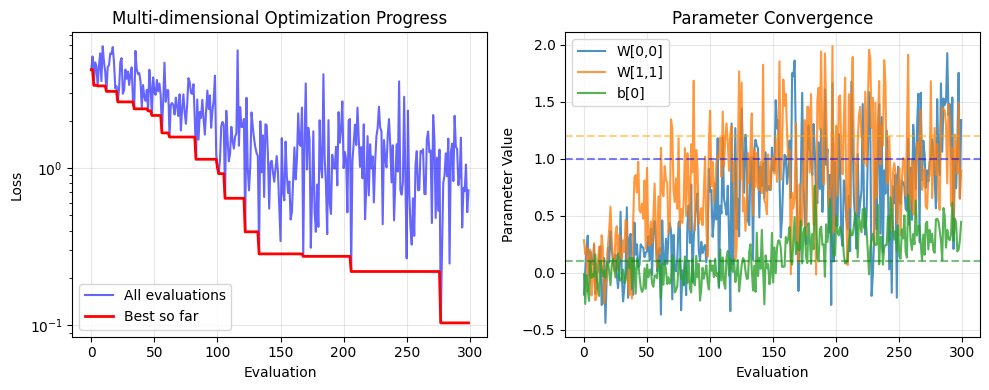

In [8]:
# Visualize optimization progress for multi-dimensional case
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(optimizer.errors, 'b-', alpha=0.6, label='All evaluations')
best_so_far = np.minimum.accumulate(optimizer.errors)
plt.plot(best_so_far, 'r-', linewidth=2, label='Best so far')
plt.yscale('log')
plt.xlabel('Evaluation')
plt.ylabel('Loss')
plt.title('Multi-dimensional Optimization Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# Show parameter convergence for a few elements
plt.subplot(1, 2, 2)
candidates = optimizer.candidates
W_evolution = [c[0] for c in candidates]  # Extract W matrices
b_evolution = [c[1] for c in candidates]  # Extract b vectors

# Plot evolution of W[0,0], W[1,1], and b[0]
W_00 = [W[0, 0] for W in W_evolution]
W_11 = [W[1, 1] for W in W_evolution]
b_0 = [b[0] for b in b_evolution]

plt.plot(W_00, label='W[0,0]', alpha=0.8)
plt.plot(W_11, label='W[1,1]', alpha=0.8)
plt.plot(b_0, label='b[0]', alpha=0.8)

# Target values
plt.axhline(y=W_target[0, 0], color='blue', linestyle='--', alpha=0.5)
plt.axhline(y=W_target[1, 1], color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=b_target[0], color='green', linestyle='--', alpha=0.5)

plt.xlabel('Evaluation')
plt.ylabel('Parameter Value')
plt.title('Parameter Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Named Parameters with Dictionary Bounds

For better organization, especially with many parameters, you can use dictionary bounds to give meaningful names to your parameters.

In [9]:
# Define a loss function that accepts named parameters
def named_loss(**params):
    """
    Loss function with named parameters.
    
    Args:
        **params: Dictionary with keys 'learning_rate', 'momentum', 'weight_decay'
                 Each value is a JAX array of shape (n_sample,)
                 
    Returns:
        Array of losses, shape (n_sample,)
    """
    lr = params['learning_rate']
    momentum = params['momentum']
    weight_decay = params['weight_decay']

    # Simulate a validation loss based on hyperparameters
    # This is a synthetic example - in practice, you'd train a model
    optimal_lr = 0.001
    optimal_momentum = 0.9
    optimal_wd = 0.0001

    lr_penalty = (jnp.log(lr) - jnp.log(optimal_lr)) ** 2
    momentum_penalty = (momentum - optimal_momentum) ** 2
    wd_penalty = (jnp.log(weight_decay + 1e-8) - jnp.log(optimal_wd)) ** 2

    # Add some noise to simulate real hyperparameter optimization
    noise = 0.1 * jax.random.normal(jax.random.PRNGKey(42), lr.shape)

    return lr_penalty + momentum_penalty + wd_penalty + noise


# Define named bounds
bounds = {
    'learning_rate': (1e-5, 1e-1),  # Log scale is often better for learning rates
    'momentum': (0.5, 0.99),
    'weight_decay': (1e-6, 1e-2),
}

# Create optimizer
optimizer = braintools.optim.NevergradOptimizer(
    batched_loss_fun=named_loss,
    bounds=bounds,
    n_sample=15,
    method='TwoPointsDE'  # Two-point Differential Evolution
)

print("Named parameter optimizer created!")
print(f"Parameters: {list(bounds.keys())}")

Named parameter optimizer created!
Parameters: ['learning_rate', 'momentum', 'weight_decay']


In [10]:
# Run optimization
best_params = optimizer.minimize(n_iter=25, verbose=True)

print(f"\nOptimal hyperparameters found:")
for param_name, value in best_params.items():
    print(f"  {param_name}: {value:.6f}")

print(f"\nTrue optimal values:")
print(f"  learning_rate: 0.001000")
print(f"  momentum: 0.900000")
print(f"  weight_decay: 0.000100")

Iteration 0, best error: 5.47494, best parameters: {'learning_rate': 0.009383971149458234, 'momentum': 0.9691190314635103, 'weight_decay': 0.00018051704200176024}
Iteration 1, best error: 5.47494, best parameters: {'learning_rate': 0.009383971149458234, 'momentum': 0.9691190314635103, 'weight_decay': 0.00018051704200176024}
Iteration 2, best error: 5.47494, best parameters: {'learning_rate': 0.009383971149458234, 'momentum': 0.9691190314635103, 'weight_decay': 0.00018051704200176024}
Iteration 3, best error: 4.44929, best parameters: {'learning_rate': 0.0029384439812353415, 'momentum': 0.8719176183870795, 'weight_decay': 0.0006102275151344754}
Iteration 4, best error: 2.34815, best parameters: {'learning_rate': 0.000501531539502326, 'momentum': 0.9870790594480003, 'weight_decay': 0.000397248490393415}
Iteration 5, best error: 2.25207, best parameters: {'learning_rate': 0.0038051526275209723, 'momentum': 0.8041034810236244, 'weight_decay': 0.00018051704200176054}
Iteration 6, best error

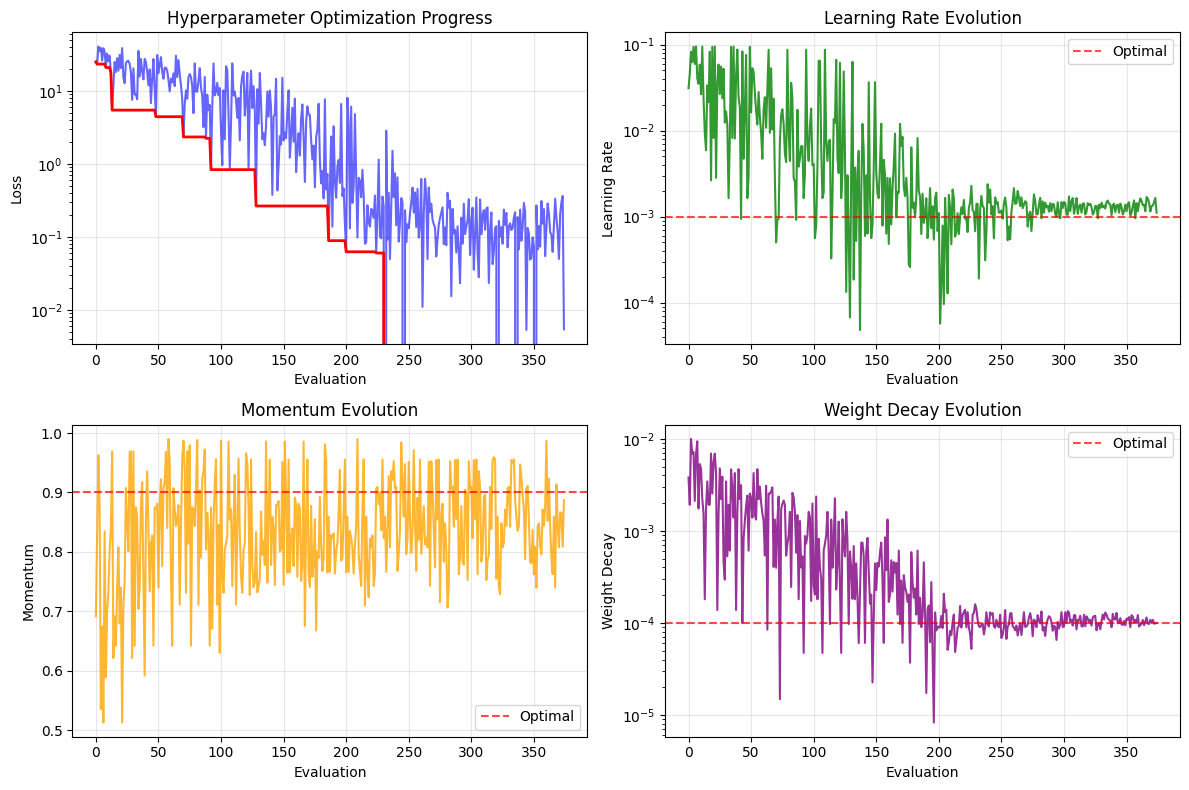

In [11]:
# Visualize hyperparameter optimization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Error evolution
axes[0, 0].plot(optimizer.errors, 'b-', alpha=0.6)
best_so_far = np.minimum.accumulate(optimizer.errors)
axes[0, 0].plot(best_so_far, 'r-', linewidth=2)
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel('Evaluation')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Hyperparameter Optimization Progress')
axes[0, 0].grid(True, alpha=0.3)

# Extract parameter evolution
candidates = optimizer.candidates
lr_values = [c['learning_rate'] for c in candidates]
momentum_values = [c['momentum'] for c in candidates]
wd_values = [c['weight_decay'] for c in candidates]

# Learning rate evolution (log scale)
axes[0, 1].plot(lr_values, 'g-', alpha=0.8)
axes[0, 1].axhline(y=0.001, color='red', linestyle='--', alpha=0.7, label='Optimal')
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlabel('Evaluation')
axes[0, 1].set_ylabel('Learning Rate')
axes[0, 1].set_title('Learning Rate Evolution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Momentum evolution
axes[1, 0].plot(momentum_values, 'orange', alpha=0.8)
axes[1, 0].axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='Optimal')
axes[1, 0].set_xlabel('Evaluation')
axes[1, 0].set_ylabel('Momentum')
axes[1, 0].set_title('Momentum Evolution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Weight decay evolution (log scale)
axes[1, 1].plot(wd_values, 'purple', alpha=0.8)
axes[1, 1].axhline(y=0.0001, color='red', linestyle='--', alpha=0.7, label='Optimal')
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlabel('Evaluation')
axes[1, 1].set_ylabel('Weight Decay')
axes[1, 1].set_title('Weight Decay Evolution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Working with BrainUnit Quantities

The NevergradOptimizer seamlessly integrates with BrainUnit quantities, allowing you to optimize parameters with physical units.

In [12]:
# Define a loss function with physical parameters
def neuron_loss(tau_m, V_th, I_ext):
    """
    Loss function for neuron model parameters.
    
    Args:
        tau_m: Membrane time constant (with time units)
        V_th: Threshold voltage (with voltage units)
        I_ext: External current (with current units)
        
    Returns:
        Array of losses
    """
    # Target parameters for a realistic neuron
    tau_target = 20.0 * u.ms
    V_th_target = -50.0 * u.mV
    I_target = 100.0 * u.pA

    # Compute normalized differences
    tau_diff = ((tau_m - tau_target) / (10.0 * u.ms)) ** 2
    V_diff = ((V_th - V_th_target) / (10.0 * u.mV)) ** 2
    I_diff = ((I_ext - I_target) / (50.0 * u.pA)) ** 2

    return u.get_mantissa(tau_diff + V_diff + I_diff)


# Define bounds with units
bounds = [
    (5.0 * u.ms, 50.0 * u.ms),  # tau_m: membrane time constant
    (-80.0 * u.mV, -30.0 * u.mV),  # V_th: threshold voltage
    (10.0 * u.pA, 200.0 * u.pA),  # I_ext: external current
]

# Create optimizer
optimizer = braintools.optim.NevergradOptimizer(
    batched_loss_fun=neuron_loss,
    bounds=bounds,
    n_sample=12,
    method='PSO'  # Particle Swarm Optimization
)

print("Neuron parameter optimizer with units created!")
print(f"tau_m bounds: {bounds[0][0]} to {bounds[0][1]}")
print(f"V_th bounds: {bounds[1][0]} to {bounds[1][1]}")
print(f"I_ext bounds: {bounds[2][0]} to {bounds[2][1]}")

Neuron parameter optimizer with units created!
tau_m bounds: 5.0 * msecond to 50.0 * msecond
V_th bounds: -80.0 * mvolt to -30.0 * mvolt
I_ext bounds: 10.0 * pamp to 200.0 * pamp


In [13]:
# Run optimization with units
best_params = optimizer.minimize(n_iter=20, verbose=True)

tau_best, V_th_best, I_best = best_params

print(f"\nOptimal neuron parameters:")
print(f"  tau_m: {tau_best}")
print(f"  V_th: {V_th_best}")
print(f"  I_ext: {I_best}")

print(f"\nTarget parameters:")
print(f"  tau_m: {20.0 * u.ms}")
print(f"  V_th: {-50.0 * u.mV}")
print(f"  I_ext: {100.0 * u.pA}")

# Evaluate final loss
final_loss = neuron_loss(tau_best, V_th_best, I_best)
print(f"\nFinal loss: {final_loss:.6f}")

Iteration 0, best error: 0.06290, best parameters: [20.869514 * msecond, -47.689476 * mvolt, 97.78947 * pamp]
Iteration 1, best error: 0.06290, best parameters: [20.869514 * msecond, -47.689476 * mvolt, 97.78947 * pamp]
Iteration 2, best error: 0.06290, best parameters: [20.869514 * msecond, -47.689476 * mvolt, 97.78947 * pamp]
Iteration 3, best error: 0.06290, best parameters: [20.869514 * msecond, -47.689476 * mvolt, 97.78947 * pamp]
Iteration 4, best error: 0.06290, best parameters: [20.869514 * msecond, -47.689476 * mvolt, 97.78947 * pamp]
Iteration 5, best error: 0.06290, best parameters: [20.869514 * msecond, -47.689476 * mvolt, 97.78947 * pamp]
Iteration 6, best error: 0.06290, best parameters: [20.869514 * msecond, -47.689476 * mvolt, 97.78947 * pamp]
Iteration 7, best error: 0.06290, best parameters: [20.869514 * msecond, -47.689476 * mvolt, 97.78947 * pamp]
Iteration 8, best error: 0.04136, best parameters: [20.60706 * msecond, -48.807583 * mvolt, 107.65714 * pamp]
Iteration 

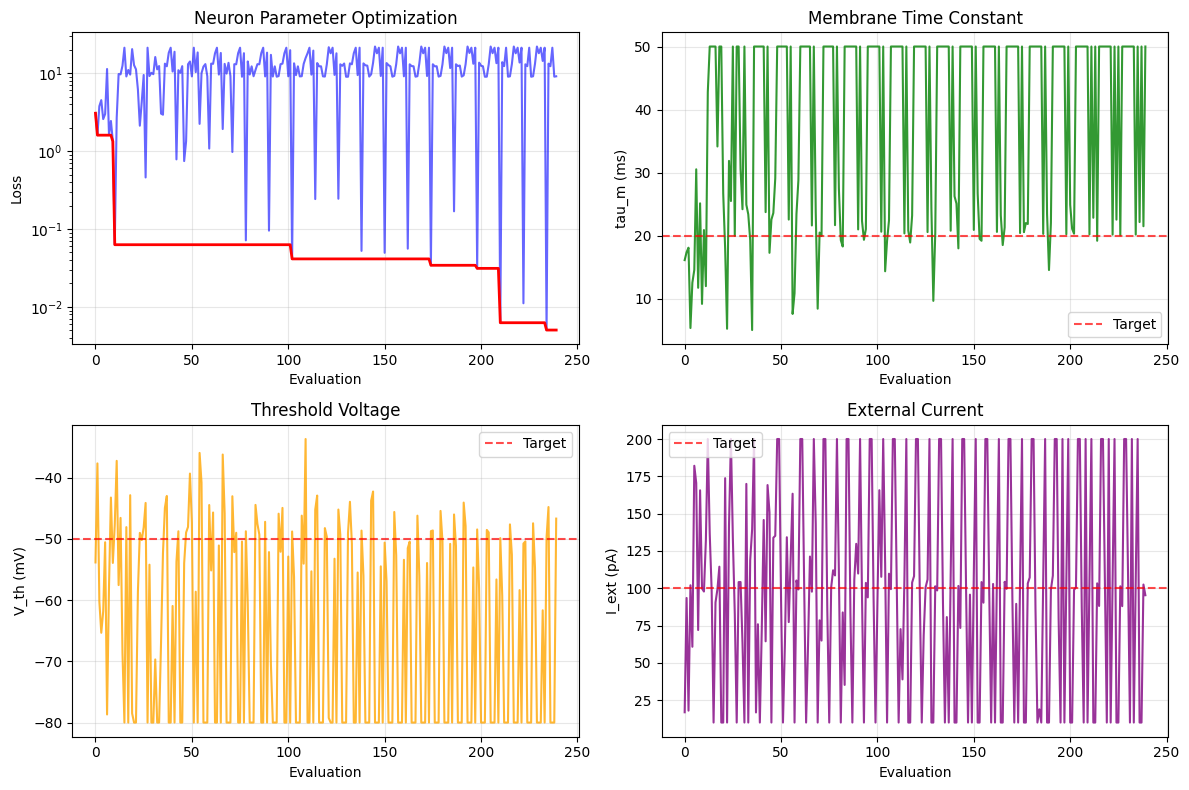

In [14]:
# Visualize parameter evolution with units
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Error evolution
axes[0, 0].plot(optimizer.errors, 'b-', alpha=0.6)
best_so_far = np.minimum.accumulate(optimizer.errors)
axes[0, 0].plot(best_so_far, 'r-', linewidth=2)
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel('Evaluation')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Neuron Parameter Optimization')
axes[0, 0].grid(True, alpha=0.3)

# Extract parameter evolution (convert to base units for plotting)
candidates = optimizer.candidates
tau_values = [c[0] for c in candidates]
V_values = [c[1] for c in candidates]
I_values = [c[2] for c in candidates]

# Tau evolution
axes[0, 1].plot(tau_values, 'g-', alpha=0.8)
axes[0, 1].axhline(y=20.0, color='red', linestyle='--', alpha=0.7, label='Target')
axes[0, 1].set_xlabel('Evaluation')
axes[0, 1].set_ylabel('tau_m (ms)')
axes[0, 1].set_title('Membrane Time Constant')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Voltage threshold evolution
axes[1, 0].plot(V_values, 'orange', alpha=0.8)
axes[1, 0].axhline(y=-50.0, color='red', linestyle='--', alpha=0.7, label='Target')
axes[1, 0].set_xlabel('Evaluation')
axes[1, 0].set_ylabel('V_th (mV)')
axes[1, 0].set_title('Threshold Voltage')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Current evolution
axes[1, 1].plot(I_values, 'purple', alpha=0.8)
axes[1, 1].axhline(y=100.0, color='red', linestyle='--', alpha=0.7, label='Target')
axes[1, 1].set_xlabel('Evaluation')
axes[1, 1].set_ylabel('I_ext (pA)')
axes[1, 1].set_title('External Current')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Different Optimization Methods

The NevergradOptimizer supports many different optimization algorithms. Let's compare a few of them on the same problem.

In [15]:
# Define a challenging test function (Rosenbrock)
def rosenbrock_loss(x, y):
    """
    The Rosenbrock function - a classic optimization benchmark.
    Global minimum at (1, 1) with value 0.
    """
    a = 1.0
    b = 100.0
    return (a - x) ** 2 + b * (y - x ** 2) ** 2


bounds = [(-2.0, 2.0), (-1.0, 3.0)]

# Test different methods
methods = ['DE', 'CMA', 'PSO', 'OnePlusOne', 'TwoPointsDE']
results = {}
n_iter = 30

for method in methods:
    print(f"\nTesting {method}...")

    optimizer = braintools.optim.NevergradOptimizer(
        batched_loss_fun=rosenbrock_loss,
        bounds=bounds,
        n_sample=10,
        method=method
    )

    best_params = optimizer.minimize(n_iter=n_iter, verbose=False)
    final_loss = rosenbrock_loss(best_params[0], best_params[1])

    results[method] = {
        'best_params': best_params,
        'final_loss': final_loss,
        'errors': optimizer.errors.copy(),
        'candidates': [c for c in optimizer.candidates]
    }

    print(f"  Final loss: {final_loss:.6f}")
    print(f"  Best params: ({best_params[0]:.4f}, {best_params[1]:.4f})")

print("\nMethod comparison completed!")


Testing DE...
  Final loss: 0.018676
  Best params: (0.9207, 0.8365)

Testing CMA...
  Final loss: 1.354735
  Best params: (-0.1639, 0.0256)

Testing PSO...
  Final loss: 0.000568
  Best params: (0.9793, 0.9578)

Testing OnePlusOne...
  Final loss: 0.025147
  Best params: (0.8414, 0.7078)

Testing TwoPointsDE...
  Final loss: 0.004973
  Best params: (0.9440, 0.8869)

Method comparison completed!


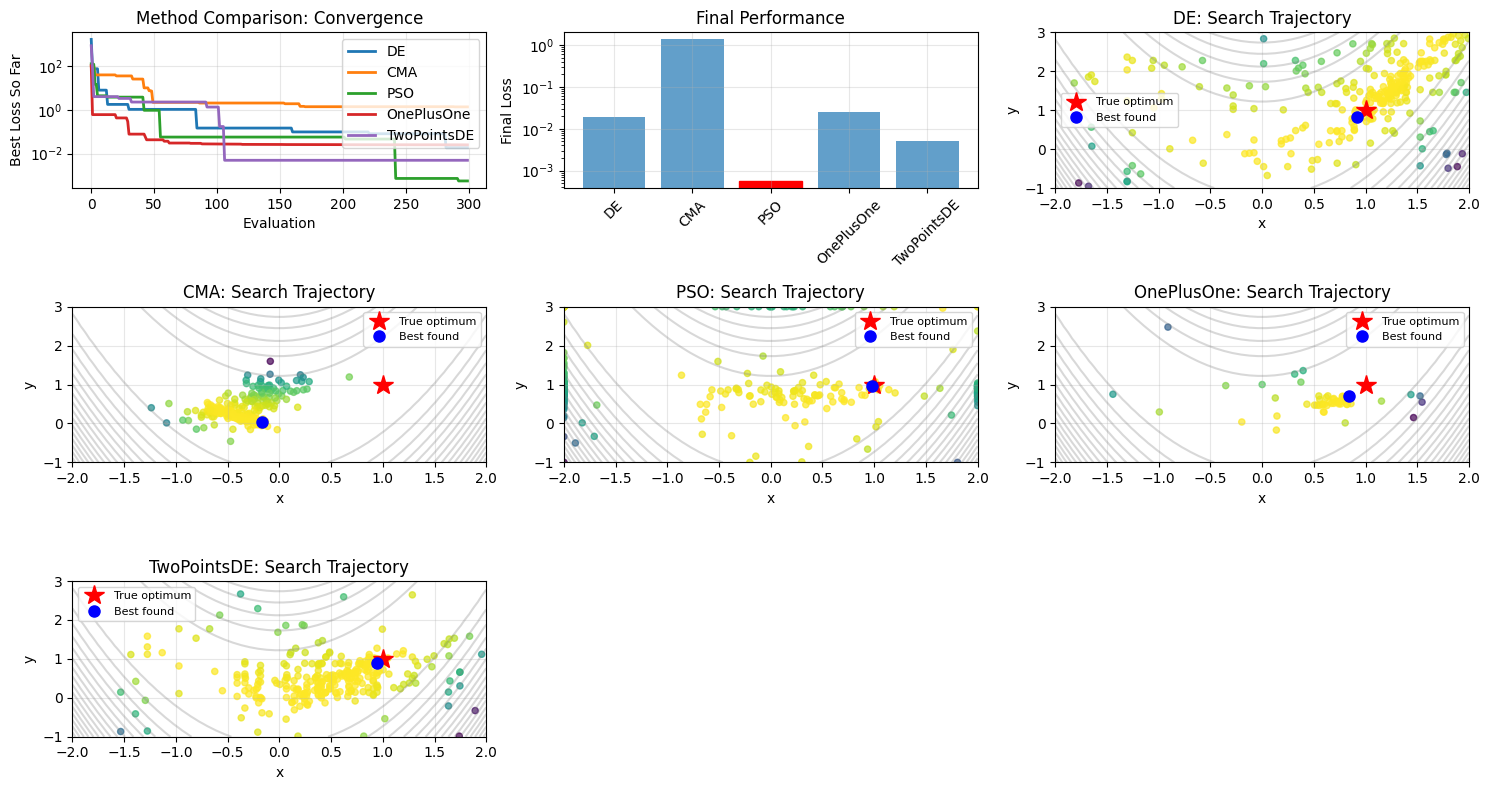


Method Performance Summary:
DE          : Loss = 0.018676, Params = (0.9207, 0.8365)
CMA         : Loss = 1.354735, Params = (-0.1639, 0.0256)
PSO         : Loss = 0.000568, Params = (0.9793, 0.9578)
OnePlusOne  : Loss = 0.025147, Params = (0.8414, 0.7078)
TwoPointsDE : Loss = 0.004973, Params = (0.9440, 0.8869)


In [16]:
# Visualize method comparison
fig, axes = plt.subplots(3, 3, figsize=(15, 8))
axes = axes.flatten()

# Plot convergence curves
ax = axes[0]
for method, result in results.items():
    best_so_far = np.minimum.accumulate(result['errors'])
    ax.plot(best_so_far, label=method, linewidth=2)

ax.set_yscale('log')
ax.set_xlabel('Evaluation')
ax.set_ylabel('Best Loss So Far')
ax.set_title('Method Comparison: Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot final results
ax = axes[1]
method_names = list(results.keys())
final_losses = [results[m]['final_loss'] for m in method_names]
bars = ax.bar(method_names, final_losses, alpha=0.7)
ax.set_yscale('log')
ax.set_ylabel('Final Loss')
ax.set_title('Final Performance')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Highlight best method
best_method_idx = np.argmin(final_losses)
bars[best_method_idx].set_color('red')
bars[best_method_idx].set_alpha(1.0)

# Plot search trajectories for each method
colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
for i, (method, result) in enumerate(results.items()):
    ax = axes[2 + i]
    candidates = np.array(result['candidates'])
    errors = result['errors']

    # Plot contour of Rosenbrock function
    x = np.linspace(-2, 2, 50)
    y = np.linspace(-1, 3, 50)
    X, Y = np.meshgrid(x, y)
    Z = (1 - X) ** 2 + 100 * (Y - X ** 2) ** 2
    ax.contour(X, Y, Z, levels=20, alpha=0.3, colors='gray')

    # Plot search points
    scatter = ax.scatter(candidates[:, 0], candidates[:, 1],
                         c=errors, cmap='viridis_r', alpha=0.7, s=20)

    # Mark true optimum and best found
    ax.plot(1, 1, 'r*', markersize=15, label='True optimum')
    best_params = result['best_params']
    ax.plot(best_params[0], best_params[1], 'bo', markersize=8,
            label='Best found')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{method}: Search Trajectory')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(2 + len(methods), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Print summary
print("\nMethod Performance Summary:")
for method, result in results.items():
    print(f"{method:12s}: Loss = {result['final_loss']:.6f}, "
          f"Params = ({result['best_params'][0]:.4f}, {result['best_params'][1]:.4f})")

## Neural Network Hyperparameter Tuning

Let's see a more realistic example: optimizing hyperparameters for a simple neural network on a classification task.

In [17]:
# Generate synthetic classification data
np.random.seed(42)
n_samples = 1000
n_features = 10

# Create synthetic data
X = np.random.randn(n_samples, n_features)
# Create a non-linear decision boundary
y = ((X[:, 0] + 0.5 * X[:, 1] ** 2 + 0.3 * X[:, 2] * X[:, 3]) > 0).astype(int)

# Split into train/test
split = int(0.8 * n_samples)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Class distribution: {np.bincount(y_train)}")

Training set: 800 samples
Test set: 200 samples
Class distribution: [274 526]


In [18]:
# Define a simple neural network training function
def train_and_evaluate_network(**hyperparams):
    """
    Train a neural network with given hyperparameters and return validation loss.
    
    Args:
        **hyperparams: Dictionary containing 'hidden_size', 'learning_rate', 'l2_reg'
                      Each value is a JAX array of shape (n_sample,)
    
    Returns:
        Array of validation losses, shape (n_sample,)
    """
    hidden_sizes = hyperparams['hidden_size'].astype(int)
    learning_rates = hyperparams['learning_rate']
    l2_regs = hyperparams['l2_reg']

    losses = []

    for hidden_size, lr, l2_reg in zip(hidden_sizes, learning_rates, l2_regs):
        # Initialize network parameters
        key = jax.random.PRNGKey(42)
        k1, k2 = jax.random.split(key)

        # Simple 2-layer network
        W1 = jax.random.normal(k1, (n_features, hidden_size)) * 0.1
        b1 = jnp.zeros(hidden_size)
        W2 = jax.random.normal(k2, (hidden_size, 1)) * 0.1
        b2 = jnp.zeros(1)

        params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        # Simple training loop (simplified for demo)
        def loss_fn(params, x, y):
            h = jax.nn.relu(x @ params['W1'] + params['b1'])
            logits = h @ params['W2'] + params['b2']
            # Binary cross-entropy loss
            loss = jnp.mean(jnp.log(1 + jnp.exp(-y[:, None] * logits)))
            # L2 regularization
            l2_loss = l2_reg * (jnp.sum(params['W1'] ** 2) + jnp.sum(params['W2'] ** 2))
            return loss + l2_loss

        grad_fn = jax.grad(loss_fn)

        # Convert labels to {-1, 1}
        y_train_signed = 2 * y_train - 1
        y_test_signed = 2 * y_test - 1

        # Training loop (simplified)
        for epoch in range(50):
            grads = grad_fn(params, X_train, y_train_signed)
            # Simple SGD update
            params = {k: v - lr * grads[k] for k, v in params.items()}

        # Evaluate on test set
        test_loss = loss_fn(params, X_test, y_test_signed)
        losses.append(float(test_loss))

    return jnp.array(losses)


# Define hyperparameter bounds
hyperparameter_bounds = {
    'hidden_size': (10, 100),  # Number of hidden units
    'learning_rate': (1e-4, 1e-1),  # Learning rate
    'l2_reg': (1e-6, 1e-2),  # L2 regularization
}

print("Neural network hyperparameter optimization setup complete!")

Neural network hyperparameter optimization setup complete!


In [19]:
# Create and run hyperparameter optimizer
optimizer = braintools.optim.NevergradOptimizer(
    batched_loss_fun=train_and_evaluate_network,
    bounds=hyperparameter_bounds,
    n_sample=8,  # Smaller batch size since training is expensive
    method='CMA',
    use_nevergrad_recommendation=True  # Use Nevergrad's recommendation
)

print("Starting hyperparameter optimization...")
print("(This may take a moment as we're actually training networks)")

best_hyperparams = optimizer.minimize(n_iter=15, verbose=True)

print(f"\nOptimal hyperparameters:")
print(f"  Hidden size: {int(best_hyperparams['hidden_size'])}")
print(f"  Learning rate: {best_hyperparams['learning_rate']:.6f}")
print(f"  L2 regularization: {best_hyperparams['l2_reg']:.6f}")
print(f"\nBest validation loss: {np.min(optimizer.errors):.6f}")

Starting hyperparameter optimization...
(This may take a moment as we're actually training networks)
Iteration 0, best error: 0.62158, best parameters: {'hidden_size': 55.72615785312022, 'learning_rate': 0.049378885537207005, 'l2_reg': 0.004330238788185962}
Iteration 1, best error: 0.61371, best parameters: {'hidden_size': 56.35320997926537, 'learning_rate': 0.05471933175493087, 'l2_reg': 0.004505735949617119}
Iteration 2, best error: 0.61371, best parameters: {'hidden_size': 56.35320997926537, 'learning_rate': 0.05471933175493087, 'l2_reg': 0.004505735949617119}
Iteration 3, best error: 0.60838, best parameters: {'hidden_size': 57.407793541579316, 'learning_rate': 0.05653133878150727, 'l2_reg': 0.003631914774644863}
Iteration 4, best error: 0.60522, best parameters: {'hidden_size': 57.407793541579316, 'learning_rate': 0.05653133878150727, 'l2_reg': 0.003631914774644863}
Iteration 5, best error: 0.60331, best parameters: {'hidden_size': 56.11874863311255, 'learning_rate': 0.05390213434

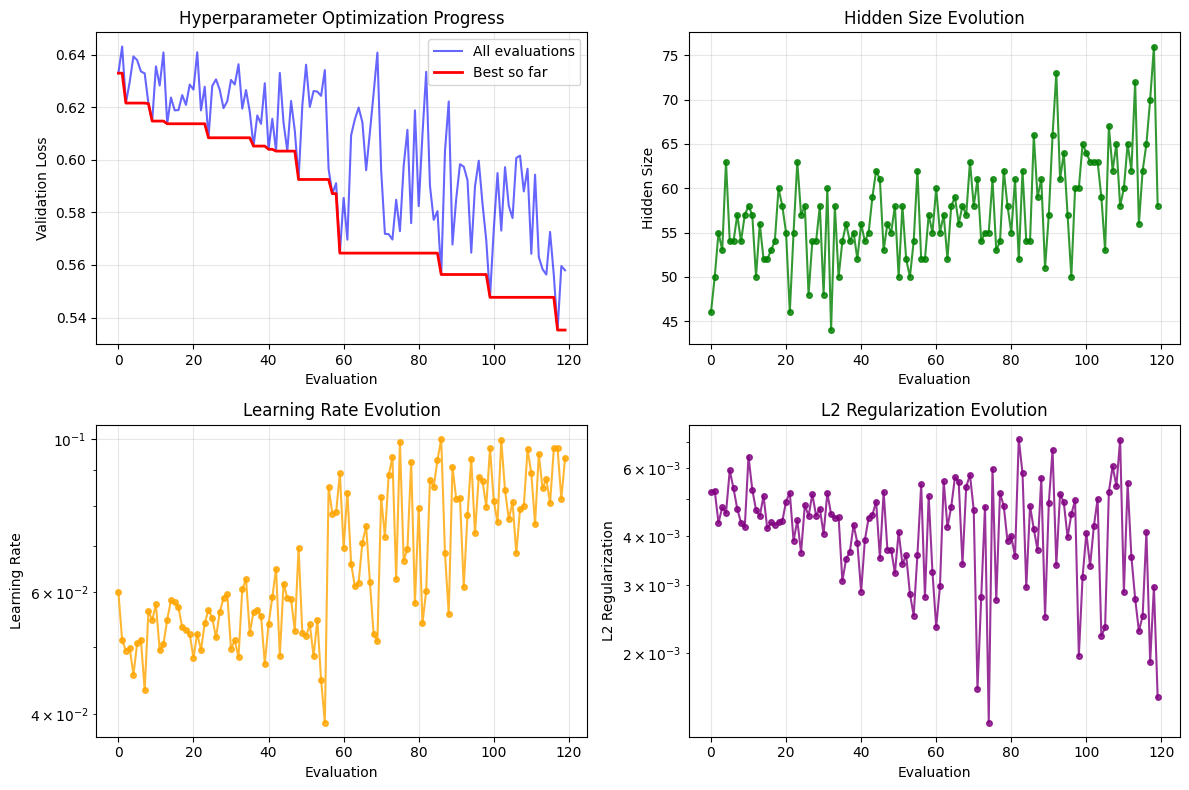


Hyperparameter vs Performance Analysis:
Best performing hidden size: 70
Best performing learning rate: 0.096840
Best performing L2 reg: 0.001896


In [20]:
# Visualize hyperparameter optimization results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Optimization progress
axes[0, 0].plot(optimizer.errors, 'b-', alpha=0.6, label='All evaluations')
best_so_far = np.minimum.accumulate(optimizer.errors)
axes[0, 0].plot(best_so_far, 'r-', linewidth=2, label='Best so far')
axes[0, 0].set_xlabel('Evaluation')
axes[0, 0].set_ylabel('Validation Loss')
axes[0, 0].set_title('Hyperparameter Optimization Progress')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Extract hyperparameter evolution
candidates = optimizer.candidates
hidden_sizes = [int(c['hidden_size']) for c in candidates]
learning_rates = [c['learning_rate'] for c in candidates]
l2_regs = [c['l2_reg'] for c in candidates]

# Hidden size evolution
axes[0, 1].plot(hidden_sizes, 'g-', alpha=0.8, marker='o', markersize=4)
axes[0, 1].set_xlabel('Evaluation')
axes[0, 1].set_ylabel('Hidden Size')
axes[0, 1].set_title('Hidden Size Evolution')
axes[0, 1].grid(True, alpha=0.3)

# Learning rate evolution
axes[1, 0].plot(learning_rates, 'orange', alpha=0.8, marker='o', markersize=4)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Evaluation')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Evolution')
axes[1, 0].grid(True, alpha=0.3)

# L2 regularization evolution
axes[1, 1].plot(l2_regs, 'purple', alpha=0.8, marker='o', markersize=4)
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlabel('Evaluation')
axes[1, 1].set_ylabel('L2 Regularization')
axes[1, 1].set_title('L2 Regularization Evolution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show correlation between hyperparameters and performance
print("\nHyperparameter vs Performance Analysis:")
print(f"Best performing hidden size: {hidden_sizes[np.argmin(optimizer.errors)]}")
print(f"Best performing learning rate: {learning_rates[np.argmin(optimizer.errors)]:.6f}")
print(f"Best performing L2 reg: {l2_regs[np.argmin(optimizer.errors)]:.6f}")

## Advanced Features

Let's explore some advanced features of the NevergradOptimizer.

In [21]:
# Advanced example: Custom method parameters and budget constraints
def complex_loss(**params):
    """
    A more complex loss function with multiple local minima.
    """
    x = params['x']
    y = params['y']
    z = params['z']

    # Multi-modal function with several local minima
    loss1 = jnp.sin(5 * x) * jnp.cos(5 * y) + (x - 0.2) ** 2 + (y + 0.3) ** 2
    loss2 = 0.1 * (z - 1.5) ** 2

    return loss1 + loss2


bounds = {
    'x': (-1.0, 1.0),
    'y': (-1.0, 1.0),
    'z': (0.0, 3.0),
}

# Create optimizer with custom method parameters
optimizer = braintools.optim.NevergradOptimizer(
    batched_loss_fun=complex_loss,
    bounds=bounds,
    n_sample=20,
    method='CMA',
    budget=300,  # Limit total evaluations
    num_workers=1,
    # method_params={
    #     'sigma': 0.5,  # Initial step size for CMA-ES
    # },
    use_nevergrad_recommendation=True
)

print("Advanced optimizer with budget and custom parameters created!")
print(f"Budget: {optimizer.budget} evaluations")
print(f"Method parameters: {optimizer.method_params}")

Advanced optimizer with budget and custom parameters created!
Budget: 300 evaluations
Method parameters: {}


In [22]:
# Run optimization with budget constraint
best_params = optimizer.minimize(n_iter=15, verbose=True)

print(f"\nOptimization completed with budget constraint")
print(f"Total evaluations: {len(optimizer.errors)}")
print(f"Best parameters: x={best_params['x']:.4f}, y={best_params['y']:.4f}, z={best_params['z']:.4f}")
print(f"Best loss: {np.min(optimizer.errors):.6f}")

Iteration 0, best error: -0.62136, best parameters: {'x': -0.311048244098807, 'y': 0.02788643240639415, 'z': 1.5372617684679157}
Iteration 1, best error: -0.62144, best parameters: {'x': -0.311048244098807, 'y': 0.02788643240639415, 'z': 1.5372617684679157}
Iteration 2, best error: -0.66273, best parameters: {'x': -0.27458126887851286, 'y': -0.01659419012402761, 'z': 1.821264714382406}
Iteration 3, best error: -0.66273, best parameters: {'x': -0.27458126887851286, 'y': -0.01659419012402761, 'z': 1.821264714382406}


C:\Users\adadu\miniconda3\envs\bdp\Lib\site-packages\cma\evolution_strategy.py:2936: InjectionWarning: orphanated injected solution {'iteration': 1, 'index': 0, 'counter': 0}
                            This could be a bug in the calling order/logics or due to
                            a too small popsize used in `ask()` or when only using
                            `ask(1)` repeatedly. Please check carefully.
                            In case this is desired, the warning can be surpressed with
                            ``warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)``
                            
  warnings.warn("""orphanated injected solution %s
C:\Users\adadu\miniconda3\envs\bdp\Lib\site-packages\cma\evolution_strategy.py:2936: InjectionWarning: orphanated injected solution {'iteration': 3, 'index': 0, 'counter': 1}
                            This could be a bug in the calling order/logics or due to
                            a too small popsize u

Iteration 4, best error: -0.66273, best parameters: {'x': -0.27458126887851286, 'y': -0.01659419012402761, 'z': 1.821264714382406}
Iteration 5, best error: -0.66353, best parameters: {'x': -0.2909894718851514, 'y': -0.033045808952976305, 'z': 1.6975710509505424}
Iteration 6, best error: -0.66353, best parameters: {'x': -0.2909894718851514, 'y': -0.033045808952976305, 'z': 1.6975710509505424}
Iteration 7, best error: -0.67070, best parameters: {'x': -0.2909894718851514, 'y': -0.033045808952976305, 'z': 1.6975710509505424}
Iteration 8, best error: -0.67070, best parameters: {'x': -0.2744329472588286, 'y': -0.023087308440185417, 'z': 1.7503477157619711}


C:\Users\adadu\miniconda3\envs\bdp\Lib\site-packages\cma\evolution_strategy.py:2936: InjectionWarning: orphanated injected solution {'iteration': 6, 'index': 0, 'counter': 1}
                            This could be a bug in the calling order/logics or due to
                            a too small popsize used in `ask()` or when only using
                            `ask(1)` repeatedly. Please check carefully.
                            In case this is desired, the warning can be surpressed with
                            ``warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)``
                            
  warnings.warn("""orphanated injected solution %s
C:\Users\adadu\miniconda3\envs\bdp\Lib\site-packages\cma\evolution_strategy.py:2936: InjectionWarning: orphanated injected solution {'iteration': 7, 'index': 0, 'counter': 1}
                            This could be a bug in the calling order/logics or due to
                            a too small popsize u

Iteration 9, best error: -0.67070, best parameters: {'x': -0.2744329472588286, 'y': -0.023087308440185417, 'z': 1.7503477157619711}
Iteration 10, best error: -0.67070, best parameters: {'x': -0.2744329472588286, 'y': -0.023087308440185417, 'z': 1.7503477157619711}
Iteration 11, best error: -0.67070, best parameters: {'x': -0.2748475989704158, 'y': -0.021836972402086707, 'z': 1.7384099131250397}
Iteration 12, best error: -0.67070, best parameters: {'x': -0.27842131476021775, 'y': -0.022420418064458564, 'z': 1.7276357553062276}


C:\Users\adadu\miniconda3\envs\bdp\Lib\site-packages\cma\evolution_strategy.py:2936: InjectionWarning: orphanated injected solution {'iteration': 10, 'index': 0, 'counter': 1}
                            This could be a bug in the calling order/logics or due to
                            a too small popsize used in `ask()` or when only using
                            `ask(1)` repeatedly. Please check carefully.
                            In case this is desired, the warning can be surpressed with
                            ``warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)``
                            
  warnings.warn("""orphanated injected solution %s
C:\Users\adadu\miniconda3\envs\bdp\Lib\site-packages\cma\evolution_strategy.py:2936: InjectionWarning: orphanated injected solution {'iteration': 11, 'index': 0, 'counter': 1}
                            This could be a bug in the calling order/logics or due to
                            a too small popsize

Iteration 13, best error: -0.67070, best parameters: {'x': -0.27842131476021775, 'y': -0.022420418064458564, 'z': 1.7276357553062276}
Iteration 14, best error: -0.67070, best parameters: {'x': -0.27704310792891923, 'y': -0.0221970706220294, 'z': 1.706428302258128}

Optimization completed with budget constraint
Total evaluations: 300
Best parameters: x=-0.2770, y=-0.0222, z=1.7064
Best loss: -0.670704


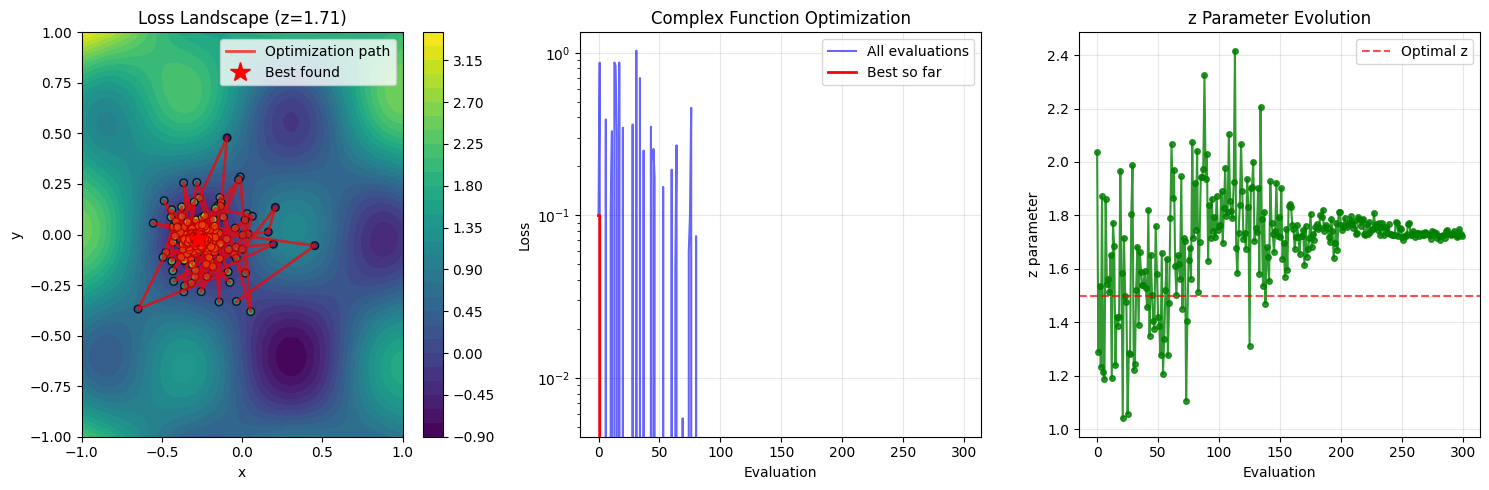

In [23]:
# Visualize the complex optimization landscape
fig = plt.figure(figsize=(15, 5))

# Plot 2D slice of the loss function (fixing z at optimal value)
ax1 = fig.add_subplot(131)
x_grid = np.linspace(-1, 1, 100)
y_grid = np.linspace(-1, 1, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
Z_optimal = best_params['z']

# Compute loss over the grid
Z_grid = np.zeros_like(X_grid)
for i in range(X_grid.shape[0]):
    for j in range(X_grid.shape[1]):
        loss_val = complex_loss(x=X_grid[i, j], y=Y_grid[i, j], z=Z_optimal)
        Z_grid[i, j] = float(loss_val)

contour = ax1.contourf(X_grid, Y_grid, Z_grid, levels=30, cmap='viridis')
plt.colorbar(contour, ax=ax1)

# Plot optimization trajectory
candidates = optimizer.candidates
x_traj = [c['x'] for c in candidates]
y_traj = [c['y'] for c in candidates]
ax1.plot(x_traj, y_traj, 'r-', alpha=0.7, linewidth=2, label='Optimization path')
ax1.scatter(x_traj, y_traj, c=optimizer.errors, cmap='viridis_r', s=30,
            edgecolors='black', alpha=0.8)
ax1.plot(best_params['x'], best_params['y'], 'r*', markersize=15, label='Best found')

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(f'Loss Landscape (z={Z_optimal:.2f})')
ax1.legend()

# Plot convergence
ax2 = fig.add_subplot(132)
ax2.plot(optimizer.errors, 'b-', alpha=0.6, label='All evaluations')
best_so_far = np.minimum.accumulate(optimizer.errors)
ax2.plot(best_so_far, 'r-', linewidth=2, label='Best so far')
ax2.set_yscale('log')
ax2.set_xlabel('Evaluation')
ax2.set_ylabel('Loss')
ax2.set_title('Complex Function Optimization')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot parameter evolution for z
ax3 = fig.add_subplot(133)
z_traj = [c['z'] for c in candidates]
ax3.plot(z_traj, 'g-', alpha=0.8, marker='o', markersize=4)
ax3.axhline(y=1.5, color='red', linestyle='--', alpha=0.7, label='Optimal z')
ax3.set_xlabel('Evaluation')
ax3.set_ylabel('z parameter')
ax3.set_title('z Parameter Evolution')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Best Practices and Tips

Here are some best practices for using the NevergradOptimizer effectively:

In [24]:
# Best Practice 1: Proper scaling and bounds
print("Best Practice 1: Proper parameter scaling")
print("=====================================\n")

# Good: Parameters on similar scales
good_bounds = {
    'param1': (-1.0, 1.0),
    'param2': (-2.0, 2.0),
    'param3': (-0.5, 0.5),
}

# Problematic: Very different scales
problematic_bounds = {
    'param1': (-1.0, 1.0),
    'param2': (-1000.0, 1000.0),  # Much larger scale
    'param3': (-0.001, 0.001),  # Much smaller scale
}

print("✓ Good bounds (similar scales):")
for name, (low, high) in good_bounds.items():
    print(f"  {name}: [{low}, {high}] (range: {high - low})")

print("\n❌ Problematic bounds (very different scales):")
for name, (low, high) in problematic_bounds.items():
    print(f"  {name}: [{low}, {high}] (range: {high - low})")

print("\nTip: Normalize parameters to similar ranges for better optimization.")

Best Practice 1: Proper parameter scaling

✓ Good bounds (similar scales):
  param1: [-1.0, 1.0] (range: 2.0)
  param2: [-2.0, 2.0] (range: 4.0)
  param3: [-0.5, 0.5] (range: 1.0)

❌ Problematic bounds (very different scales):
  param1: [-1.0, 1.0] (range: 2.0)
  param2: [-1000.0, 1000.0] (range: 2000.0)
  param3: [-0.001, 0.001] (range: 0.002)

Tip: Normalize parameters to similar ranges for better optimization.


In [25]:
# Best Practice 2: Choosing the right method and population size
print("\nBest Practice 2: Method and population size selection")
print("==================================================\n")

guidelines = {
    'DE': {
        'description': 'Differential Evolution - Good general purpose optimizer',
        'best_for': 'Most problems, robust and reliable',
        'population_size': '5-20 times the number of parameters',
        'pros': 'Robust, handles constraints well',
        'cons': 'Can be slow on high-dimensional problems'
    },
    'CMA': {
        'description': 'Covariance Matrix Adaptation Evolution Strategy',
        'best_for': 'Continuous optimization, high-dimensional problems',
        'population_size': 'Automatically determined, typically 4 + 3*ln(n_params)',
        'pros': 'Excellent for continuous problems, adapts to problem structure',
        'cons': 'Can be computationally expensive, sensitive to initialization'
    },
    'PSO': {
        'description': 'Particle Swarm Optimization',
        'best_for': 'Multi-modal problems, when you want exploration',
        'population_size': '20-50 particles',
        'pros': 'Good exploration, handles multiple local minima',
        'cons': 'Can be slow to converge precisely'
    },
    'OnePlusOne': {
        'description': 'Simple (1+1) evolution strategy',
        'best_for': 'Quick optimization, low-dimensional problems',
        'population_size': '1 (no population)',
        'pros': 'Fast, simple, low memory usage',
        'cons': 'Can get stuck in local minima, not suitable for noisy functions'
    }
}

for method, info in guidelines.items():
    print(f"{method}:")
    print(f"  Description: {info['description']}")
    print(f"  Best for: {info['best_for']}")
    print(f"  Population size: {info['population_size']}")
    print(f"  Pros: {info['pros']}")
    print(f"  Cons: {info['cons']}\n")


Best Practice 2: Method and population size selection

DE:
  Description: Differential Evolution - Good general purpose optimizer
  Best for: Most problems, robust and reliable
  Population size: 5-20 times the number of parameters
  Pros: Robust, handles constraints well
  Cons: Can be slow on high-dimensional problems

CMA:
  Description: Covariance Matrix Adaptation Evolution Strategy
  Best for: Continuous optimization, high-dimensional problems
  Population size: Automatically determined, typically 4 + 3*ln(n_params)
  Pros: Excellent for continuous problems, adapts to problem structure
  Cons: Can be computationally expensive, sensitive to initialization

PSO:
  Description: Particle Swarm Optimization
  Best for: Multi-modal problems, when you want exploration
  Population size: 20-50 particles
  Pros: Good exploration, handles multiple local minima
  Cons: Can be slow to converge precisely

OnePlusOne:
  Description: Simple (1+1) evolution strategy
  Best for: Quick optimizati

In [26]:
# Best Practice 3: Handling noisy objective functions
print("Best Practice 3: Dealing with noisy objectives")
print("=============================================\n")


def noisy_objective(x, y, noise_level=0.1):
    """Example of a noisy objective function."""
    true_loss = (x - 1.0) ** 2 + (y + 0.5) ** 2
    # Add noise that varies with evaluation
    noise = noise_level * jax.random.normal(
        jax.random.PRNGKey(int(1000 * (x[0] + y[0]))), x.shape
    )
    return true_loss + noise


bounds = [(-2.0, 2.0), (-2.0, 2.0)]

# Compare different approaches for noisy functions
methods_for_noise = ['DE', 'CMA', 'PSO']
noise_results = {}

for method in methods_for_noise:
    optimizer = braintools.optim.NevergradOptimizer(
        batched_loss_fun=noisy_objective,
        bounds=bounds,
        n_sample=15,  # Larger population for noisy functions
        method=method,
        use_nevergrad_recommendation=True  # Often better for noisy functions
    )

    best_params = optimizer.minimize(n_iter=20, verbose=False)
    # Evaluate true performance (without noise)
    true_loss = (best_params[0] - 1.0) ** 2 + (best_params[1] + 0.5) ** 2

    noise_results[method] = {
        'best_params': best_params,
        'true_loss': float(true_loss),
        'errors': optimizer.errors
    }

    print(f"{method}: True loss = {true_loss:.6f}, "
          f"Params = ({best_params[0]:.4f}, {best_params[1]:.4f})")

print("\nTips for noisy objectives:")
print("- Use larger population sizes (n_sample)")
print("- Set use_nevergrad_recommendation=True")
print("- Consider methods like CMA-ES that are robust to noise")
print("- Run for more iterations to allow convergence despite noise")

Best Practice 3: Dealing with noisy objectives

DE: True loss = 0.011109, Params = (1.0971, -0.4590)
CMA: True loss = 0.048718, Params = (0.8519, -0.6637)
PSO: True loss = 0.059386, Params = (1.1363, -0.7020)

Tips for noisy objectives:
- Use larger population sizes (n_sample)
- Set use_nevergrad_recommendation=True
- Consider methods like CMA-ES that are robust to noise
- Run for more iterations to allow convergence despite noise


In [27]:
# Best Practice 4: Parameter importance analysis
print("\nBest Practice 4: Understanding parameter importance")
print("================================================\n")


# Analyze which parameters matter most
def analyze_parameter_importance(optimizer_results):
    """Analyze which parameters have the most impact on the objective."""
    candidates = optimizer_results.candidates
    errors = optimizer_results.errors

    if isinstance(candidates[0], dict):
        # Dictionary-based parameters
        param_names = list(candidates[0].keys())
        param_values = {name: [c[name] for c in candidates] for name in param_names}

        print("Parameter sensitivity analysis:")
        for name in param_names:
            values = np.array(param_values[name])
            # Simple correlation with errors
            correlation = np.corrcoef(values, errors)[0, 1]
            print(f"  {name}: correlation with loss = {correlation:.4f}")

            # Range of values explored
            print(f"    Range explored: [{np.min(values):.4f}, {np.max(values):.4f}]")

        return param_values, errors
    else:
        print("Analysis for positional parameters not implemented in this demo")
        return None, None


# Use the hyperparameter optimization results from earlier
if 'optimizer' in locals() and hasattr(optimizer, 'candidates'):
    param_values, errors = analyze_parameter_importance(optimizer)

    if param_values is not None:
        # Visualize parameter importance
        fig, axes = plt.subplots(1, len(param_values), figsize=(15, 4))
        if len(param_values) == 1:
            axes = [axes]

        for i, (name, values) in enumerate(param_values.items()):
            axes[i].scatter(values, errors, alpha=0.6)
            axes[i].set_xlabel(name)
            axes[i].set_ylabel('Loss')
            axes[i].set_title(f'{name} vs Loss')
            if name in ['learning_rate', 'l2_reg']:
                axes[i].set_xscale('log')
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

print("\nTips for parameter analysis:")
print("- Look for strong correlations between parameters and loss")
print("- Parameters with low correlation might be less important")
print("- Consider fixing less important parameters to reduce search space")
print("- Use the insights to set better bounds for important parameters")


Best Practice 4: Understanding parameter importance

Analysis for positional parameters not implemented in this demo

Tips for parameter analysis:
- Look for strong correlations between parameters and loss
- Parameters with low correlation might be less important
- Consider fixing less important parameters to reduce search space
- Use the insights to set better bounds for important parameters


## Summary

In this tutorial, we've covered the key aspects of using BrainTools' `NevergradOptimizer`:

1. Key Features:

- **Batched evaluation**: Efficiently evaluate multiple parameter sets in parallel
- **Flexible bounds**: Support for both positional and named parameters
- **Unit integration**: Seamless work with BrainUnit quantities
- **Multiple algorithms**: Access to various optimization methods (DE, CMA, PSO, etc.)
- **Advanced options**: Budget constraints, custom method parameters, recommendations

2. Best Practices:
- **Scale parameters appropriately** - Keep parameter ranges on similar scales
- **Choose the right method** - Match the algorithm to your problem characteristics
- **Handle noise properly** - Use larger populations and recommendations for noisy objectives
- **Analyze results** - Understand which parameters matter most for future optimization

3. When to Use NevergradOptimizer:
- Hyperparameter optimization for neural networks
- Problems where gradients are unavailable or unreliable
- Multi-modal optimization landscapes
- Noisy objective functions
- Mixed continuous/discrete parameter spaces

The NevergradOptimizer provides a powerful and flexible interface for derivative-free optimization in the BrainTools ecosystem, making it easy to optimize complex neural network models and computational neuroscience simulations.